In [1]:
from ipywidgets import interact
from fastai.basics import *

plt.rc('figure', dpi=90)

def plot_function(f, title=None, min=-2.1, max=2.1, color='r', ylim=None):
    x = torch.linspace(min,max, 100)[:,None]
    if ylim: plt.ylim(ylim)
    plt.plot(x, f(x), color)
    if title is not None: plt.title(title)

以二次函数拟合为例，使用partial来固定函数中的某些输入量

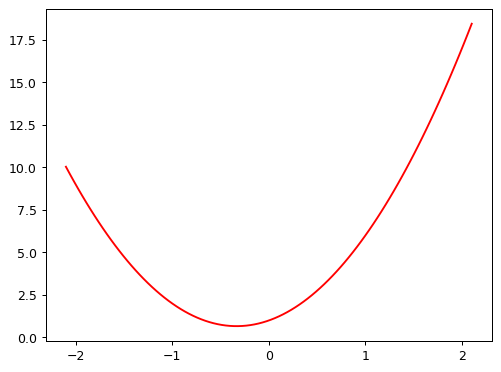

In [2]:
def quad(a, b, c, x): return a*x**2 + b*x + c

def mk_quad(a,b,c): return partial(quad, a,b,c)

f2 = mk_quad(3,2,1)
plot_function(f2)

对原始数据添加一些噪音，作为训练数据

In [3]:
def noise(x, scale): return np.random.normal(scale=scale, size=x.shape)
def add_noise(x, mult, add): return x * (1+noise(x,mult)) + noise(x,add)

np.random.seed(42)

x = torch.linspace(-2, 2, steps=20)[:,None]
y = add_noise(f2(x), 0.15, 1.5)

In [4]:
@interact(a=1.1, b=1.1, c=1.1)
def plot_quad(a, b, c):
    plt.scatter(x,y)
    plot_function(mk_quad(a,b,c), ylim=(-3,13))

interactive(children=(FloatSlider(value=1.1, description='a', max=3.3000000000000003, min=-1.1), FloatSlider(v…

可以观察到，改变参数a，b，c的大小，即刻改变模型的拟合精度。

但是我们不能只通过眼睛来判断怎样改变参数会提高精度，我们需要一个测量指标来帮助我们进行判断，因此要引入metrics的概念，以误差的绝对值的平均为例：

In [5]:
def mae(preds, acts): return (torch.abs(preds-acts)).mean()

In [6]:
@interact(a=1.1, b=1.1, c=1.1)
def plot_quad(a, b, c):
    f = mk_quad(a,b,c)
    plt.scatter(x,y)
    loss = mae(f(x), y)
    plot_function(f, ylim=(-3,12), title=f"MAE: {loss:.2f}")

interactive(children=(FloatSlider(value=1.1, description='a', max=3.3000000000000003, min=-1.1), FloatSlider(v…

在主流的神经网络中，通常有上亿的参数需要拟合，因此不能依靠每次手动调整，我们需要找到一种自动化策略：梯度下降法。

我们的目标是通过调整参数abc把损失函数mae降到最小，如果我们可以求出mae关于每个参数abc的导数，我们就知道怎么来调整这些参数。

In [11]:
# 首先构造一个损失函数用于求导
def quad_mae(params):
    f = mk_quad(*params)
    return mae(f(x), y)

# 对参数进行初始化
abc = torch.tensor([1.1,1.1,1.1])

# 告诉pytorch需要计算导数
abc.requires_grad_()

# 计算当前参数的损失
loss = quad_mae(abc)

print(f'loss={loss:.2f}')

loss=2.42


In [12]:
# 计算导数的大小
loss.backward()

# 读取导数的计算结果
abc.grad

tensor([-1.3529, -0.0316, -0.5000])

因为导数都为负数，所以我们需要把当前的参数缩小一点来提高拟合精度，每个参数缩小的幅度和导数值大小有关。

In [13]:
with torch.no_grad():
    abc -= abc.grad*0.01
    loss = quad_mae(abc)
    
print(f'loss={loss:.2f}')

loss=2.40


创建一个循环来重复上面的过程

In [14]:
for i in range(10):
    loss = quad_mae(abc)
    loss.backward()
    with torch.no_grad(): abc -= abc.grad*0.01
    print(f'step={i}; loss={loss:.2f}')

step=0; loss=2.40
step=1; loss=2.36
step=2; loss=2.30
step=3; loss=2.21
step=4; loss=2.11
step=5; loss=1.98
step=6; loss=1.85
step=7; loss=1.72
step=8; loss=1.58
step=9; loss=1.46


一个神经网络理论上可以拟合任意函数，而完成这一任务只需要两个步骤
1. 矩阵乘法：用来计算输出
2. reLU：用来引入非线性

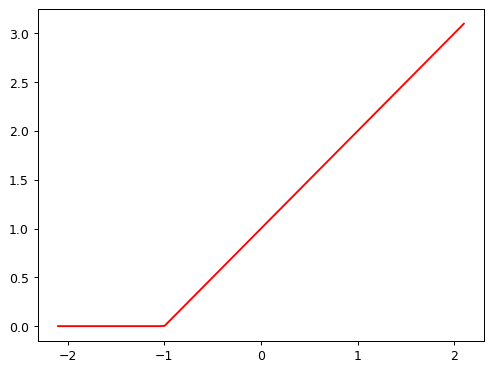

In [15]:
# 实现reLU函数
def rectified_linear(m,b,x):
    y = m*x+b
    return torch.clip(y, 0.)

plot_function(partial(rectified_linear, 1,1))

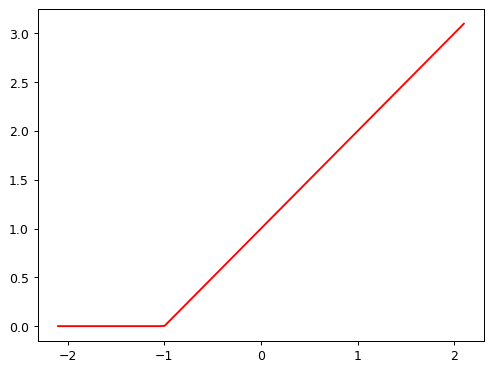

In [16]:
# 使用Pytorch中自带的reLU函数

import torch.nn.functional as F
def rectified_linear2(m,b,x): return F.relu(m*x+b)
plot_function(partial(rectified_linear2, 1,1))

In [18]:
# 探究参数值改变对于reLU输出的影响
@interact(m=1.5, b=1.5)
def plot_relu(m, b):
    plot_function(partial(rectified_linear, m,b), ylim=(-1,4))

interactive(children=(FloatSlider(value=1.5, description='m', max=4.5, min=-1.5), FloatSlider(value=1.5, descr…

In [20]:
# 如果使用的reLU足够多，仅仅通过改变参数，便可以从同样的输入中拟合出任意形状的曲线
def double_relu(m1,b1,m2,b2,x):
    return rectified_linear(m1,b1,x) + rectified_linear(m2,b2,x)

@interact(m1=-1.5, b1=-1.5, m2=1.5, b2=1.5)
def plot_double_relu(m1, b1, m2, b2):
    plot_function(partial(double_relu, m1,b1,m2,b2), ylim=(-1,6))

interactive(children=(FloatSlider(value=-1.5, description='m1', max=1.5, min=-4.5), FloatSlider(value=-1.5, de…